In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import spherical_jn
import torch.nn.functional as F


# Exact solution for ℓ=1,m=0 dipole mode
def exact_solution(x, y, z, k=4.493409, eps=1e-6):
    r = torch.sqrt(x**2 + y**2 + z**2 + eps)
    kr = k * r
    j1 = torch.sin(kr) / (kr**2) - torch.cos(kr) / kr
    return j1 * (z / r)


class Experiment(nn.Module):
    def __init__(self, num_samples=1000, bc_factor=2, num_data=200):
        super().__init__()
        # Device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # self.lambda_param = nn.Parameter(torch.tensor(1.0, requires_grad=True, device=self.device))
        self.lambda_param = torch.tensor(1.0, requires_grad=True, device=self.device)

        # Branch Network
        self.b1 = nn.Linear(3, 20).to(self.device)
        self.b2 = nn.Linear(20, 20).to(self.device)
        self.b3 = nn.Linear(20, 1).to(self.device)

        # Trunk Network
        self.t1 = nn.Linear(3, 20).to(self.device)
        self.t2 = nn.Linear(20, 20).to(self.device)
        self.t3 = nn.Linear(20, 1).to(self.device)

        # Loss weights (set later in curriculum)
        self.w_int = 1.0
        self.w_bc = 1.0
        self.w_data = 1.0
        self.w_norm = 0.1

        # Dataset sizes
        self.num_samples = num_samples
        self.bc_samples = int(num_samples * bc_factor)
        self.num_data = num_data

        # Prepare datasets
        self.create_dataset()

        # Initialize loss history
        self.loss_history = []
        self.li_history = []
        self.lb_history = []
        self.ld_history = []

    def create_dataset(self):
        N = self.num_samples
        R = torch.rand(N,1,device=self.device)**(1/3)
        X = torch.randn(N,3,device=self.device)
        X = X / X.norm(dim=1,keepdim=True)
        self.interior = (X * R).requires_grad_(True)

        M = self.bc_samples
        B = torch.randn(M,3,device=self.device)
        B = B / B.norm(dim=1,keepdim=True)
        self.boundary = B.requires_grad_(True)

        D = self.num_data
        Rd = torch.rand(D,1,device=self.device)**(1/3)
        Xd = torch.randn(D,3,device=self.device)
        Xd = Xd / Xd.norm(dim=1,keepdim=True)
        self.data_points = (Xd * Rd)

        x_d, y_d, z_d = self.data_points[:,0], self.data_points[:,1], self.data_points[:,2]
        self.data_values = exact_solution(x_d, y_d, z_d).detach()

    def forward(self, x, resample_param=True):
        h = torch.tanh(self.b1(x))
        h = torch.tanh(self.b2(h))

        x_trunk = torch.normal(mean=0, std=1, size=(x.shape[0], 3), device=self.device)
        t = torch.tanh(self.t1(x_trunk))
        prod = t*h
        u = self.b3(prod).squeeze(-1)
        param = torch.tanh(self.t2(t))
        self.lambda_param = F.relu(self.t3(param))

        return u

    def laplacian(self, u, x):
        grad_u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        lap = torch.zeros_like(u)
        for i in range(3):
            grad2 = torch.autograd.grad(grad_u[:,i], x, grad_outputs=torch.ones_like(grad_u[:,i]), create_graph=True)[0]
            lap += grad2[:,i]
        return lap

    def loss_interior(self, resample_param=True):
        x = self.interior
        u = self.forward(x, resample_param=resample_param)
        lap_u = self.laplacian(u, x).squeeze(-1)
        lap_u = lap_u.squeeze(-1)

        res = -lap_u - (self.lambda_param ** 2) * u
        loss_pde = torch.mean(res**2)
        # loss_norm = (torch.mean(u**2) - 1.0)**2
        return loss_pde

    def check_exact_residual(self):
        x = self.interior           # (N,3) with requires_grad=True
        # exact u, keep requires_grad so autograd works
        exact_u = exact_solution(x[:,0], x[:,1], x[:,2])

        lap_exact = self.laplacian(exact_u, x)   # Laplacian of the *exact* field
        lap_exact = lap_exact.squeeze(-1)        # make it (N,) not (N,1)

        k = 4.493409
        residual = -lap_exact - (k**2) * exact_u

        # print("max |residual| =", residual.abs().max().item())
        print(" norm |residual| =", (residual**2).mean().item())

    def loss_boundary(self):
        u_b = self.forward(self.boundary)
        return torch.mean(u_b**2)

    def loss_data(self):
        u_d = self.forward(self.data_points)
        return torch.mean((u_d - self.data_values)**2)

    def compute_losses(self):
        return self.loss_interior(), self.loss_boundary(), self.loss_data()

In [ ]:
# Training and plotting helpers
def pretrain(model, epochs=10, lr=1e-3):
    model.w_int = 1.0
    model.w_bc = 0.0
    model.w_norm = 0.0
    model.w_data = 1.0

    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_d = model.loss_data()
        loss_d.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print(f"Pretrain epoch {epoch}: data_loss={loss_d.item():.2e}")

# def train_full(model, epochs=1000, lr=1e-4):
#     model.w_int  = 10.0
#     model.w_bc   = 1.0
#     model.w_norm = 100.0
#     model.w_data = 100.0

#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     for epoch in range(epochs):
#         optimizer.zero_grad()
#         model.create_dataset()
#         li, lb, ld = model.compute_losses()
#         loss = model.w_int*li + model.w_bc*lb + model.w_data*ld
#         loss.backward()
#         optimizer.step()
#         if epoch % 100 == 0:
#             print(f"Epoch {epoch}: PDE={li.item():.2e}, BC={lb.item():.2e}, DATA={ld.item():.2e}, λ={model.lambda_param.mean().item():.4f}")


def train_full(model, epochs=1000, lr=1e-4):
    model.w_int  = 10.0
    model.w_bc   = 1.0
    model.w_norm = 100.0
    model.w_data = 100.0

    optimizer = optim.Adam(model.parameters(), lr=lr)

    # No need to create local histories; use model attributes!
    for epoch in range(epochs):
        optimizer.zero_grad()
        model.create_dataset()
        li, lb, ld = model.compute_losses()
        loss = model.w_int*li + model.w_bc*lb + model.w_data*ld
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            # Append losses to model’s history arrays
            model.loss_history.append(loss.item())
            model.li_history.append(li.item())
            model.lb_history.append(lb.item())
            model.ld_history.append(ld.item())
            print(
                f"Epoch {epoch}: Total Loss={loss.item():.2e}, PDE={li.item():.2e}, "
                f"BC={lb.item():.2e}, DATA={ld.item():.2e}, λ={model.lambda_param.mean().item():.4f}"
            )



def plot_axis(model):
    z = torch.linspace(-1,1,200,device=model.device)
    pts = torch.stack([torch.zeros_like(z), torch.zeros_like(z), z], dim=1)
    with torch.no_grad():
        u_pred = model(pts).cpu().numpy()
    z_np = z.cpu().numpy()
    u_ex = exact_solution(pts[:,0],pts[:,1],pts[:,2]).cpu().numpy()
    plt.plot(z_np, u_pred, label='Predicted')
    plt.plot(z_np, u_ex, '--', label='Exact')
    plt.legend()
    plt.xlabel('z')
    plt.ylabel('u')
    plt.title('Axis (x=y=0)')
    plt.tight_layout()
    plt.show()

def plot_slices(model, device, z0_list=(0.0, 0.3, 0.6)):
    """
    Compare u_pred vs. exact on:
      • axial line (x=y=0)
      • several horizontal slices z = z0
      • meridional slice (x=0 plane)

    z0_list : tuple of z-heights for the equatorial slices
    """
    model.eval()
    with torch.no_grad():
        # ---- 2) equatorial slices z = z0 --------------------
        for z0 in z0_list:
            r_max = np.sqrt(max(1e-8, 1 - z0**2))
            theta = torch.linspace(0, 2*np.pi, 361, device=device)
            r = torch.linspace(0, r_max, 200, device=device)
            R, Θ = torch.meshgrid(r, theta, indexing='ij')
            X = R*torch.cos(Θ); Y = R*torch.sin(Θ); Z = torch.full_like(X, z0)
            pts_flat = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], 1)

            # Predictions
            u_pred = model(pts_flat).reshape(R.shape).cpu().numpy()
            u_exact = exact_solution(pts_flat[:,0], pts_flat[:,1], pts_flat[:,2]).reshape(R.shape).cpu().numpy()
            u_resid = np.abs(u_exact - u_pred)

            # Title with lambda
            lambda_val = model.lambda_param.mean().item()

            fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(12, 4))
            fig.suptitle(f'Equatorial Slice z={z0:.2f} | λ ≈ {lambda_val:.4f}', fontsize=12, y=1.1)

            # for ax, data, ttl in zip(axs, [u_pred, u_exact, u_resid], ['pred', 'exact', 'abs error']):
            #     c = ax.contourf(Θ.cpu(), R.cpu(), data, levels=50)
            #     ax.text(0.5, 1.12, ttl, transform=ax.transAxes, ha='center', va='center', fontsize=10)
            #     fig.colorbar(c, ax=ax, shrink=0.8)

            for ax, data, ttl in zip(axs, [u_pred, u_exact, u_resid], ['pred', 'exact', 'abs error']):
                if ttl == 'abs error':
                    c = ax.contourf(Θ.cpu(), R.cpu(), data, levels=50, cmap='magma')
                else:
                    c = ax.contourf(Θ.cpu(), R.cpu(), data, levels=50)
                ax.text(0.5, 1.12, ttl, transform=ax.transAxes, ha='center', va='center', fontsize=10)
                fig.colorbar(c, ax=ax, shrink=0.8)

            plt.subplots_adjust(wspace=0.5)
            plt.tight_layout()


        # ---- 3) meridional slice x=0 (y–z plane) ------------
        y = torch.linspace(-1,1,301, device=device)
        z = torch.linspace(-1,1,301, device=device)
        Y, Z = torch.meshgrid(y, z, indexing='ij')
        mask = Y**2 + Z**2 <= 1.0
        X0 = torch.zeros_like(Y)
        pts_plane = torch.stack([X0[mask], Y[mask], Z[mask]], 1)
        u_pred_plane = model(pts_plane).cpu().numpy()
        u_exact_plane = exact_solution(pts_plane[:,0], pts_plane[:,1], pts_plane[:,2]).cpu().numpy()

        # put back into full grid with NaNs outside ball
        U_pred_grid = np.full(Y.shape, np.nan); U_exact_grid = np.full_like(U_pred_grid, np.nan)
        U_pred_grid[mask.cpu().numpy()]  = u_pred_plane
        U_exact_grid[mask.cpu().numpy()] = u_exact_plane

        fig,axs = plt.subplots(1,2,figsize=(8,4))
        for ax, data, ttl in zip(axs,[U_pred_grid,U_exact_grid],['pred','exact']):
            im = ax.imshow(data, origin='lower', extent=[-1,1,-1,1], cmap='seismic')
            ax.set_title(f'{ttl}  slice x=0')
            fig.colorbar(im, ax=ax, shrink=0.8)

        plt.subplots_adjust(wspace=0.4)
        plt.tight_layout()
        plt.show()

In [ ]:
if __name__ == '__main__':
    torch.manual_seed(345)
    model = Experiment()
    model.to(model.device)
    print(f"Using device: {model.device}")
    print(f"Parameters: {sum(p.numel() for p in model.parameters())}")

    # Set loss weights
    model.w_int  = 1000.0   # Interior PDE loss weight
    model.w_bc   = 1.0    # Boundary condition loss weight
    model.w_data = 1.0  # Data loss weight
    model.w_norm = 1.0  # Normalization loss weight

    # Run training
    # pretrain(model, epochs=100)
    train_full(model, epochs=30000, lr=1e-2)


Using device: cuda:0
Parameters: 1042


/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: Total Loss=2.95e+00, PDE=7.00e-04, BC=1.16e-02, DATA=2.94e-02, λ=0.0487
Epoch 100: Total Loss=1.03e+00, PDE=2.52e-03, BC=1.85e-02, DATA=9.85e-03, λ=1.3786
Epoch 200: Total Loss=1.12e+00, PDE=3.68e-03, BC=1.73e-02, DATA=1.07e-02, λ=1.5032
Epoch 300: Total Loss=1.19e+00, PDE=4.61e-03, BC=1.68e-02, DATA=1.13e-02, λ=1.6167
Epoch 400: Total Loss=1.20e+00, PDE=3.46e-03, BC=1.27e-02, DATA=1.15e-02, λ=1.6280
Epoch 500: Total Loss=1.39e+00, PDE=4.50e-03, BC=1.40e-02, DATA=1.33e-02, λ=1.7311
Epoch 600: Total Loss=1.08e+00, PDE=6.45e-03, BC=1.31e-02, DATA=1.00e-02, λ=2.0164
Epoch 700: Total Loss=9.49e-01, PDE=1.60e-02, BC=1.26e-02, DATA=7.76e-03, λ=2.8023
Epoch 800: Total Loss=5.90e-01, PDE=8.26e-03, BC=7.64e-03, DATA=5.00e-03, λ=3.4448
Epoch 900: Total Loss=4.24e-01, PDE=1.08e-02, BC=5.42e-03, DATA=3.11e-03, λ=3.6413
Epoch 1000: Total Loss=4.94e-01, PDE=1.66e-02, BC=6.01e-03, DATA=3.21e-03, λ=3.7425
Epoch 1100: Total Loss=4.06e-01, PDE=1.27e-02, BC=5.70e-03, DATA=2.73e-03, λ=3.7600
Epoc

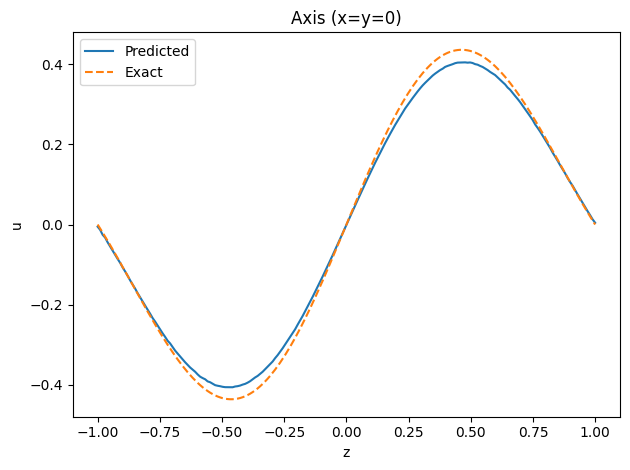

In [ ]:
plot_axis(model)

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

def plot_slices(model, device, z0_list=(0.0, 0.3, 0.6)):
    """
    Compare u_pred vs. exact on:
      • several horizontal slices z = z0 (equatorial)
      • meridional slice (x=0 plane)
    """
    model.eval()
    all_u_resid = []  # For global vmax

    with torch.no_grad():
        # ---- Pass 1: compute residuals to find global vmax ----
        for z0 in z0_list:
            r_max = np.sqrt(max(1e-8, 1 - z0**2))
            theta = torch.linspace(0, 2*np.pi, 361, device=device)
            r = torch.linspace(0, r_max, 200, device=device)
            R, Θ = torch.meshgrid(r, theta, indexing='ij')
            X = R * torch.cos(Θ)
            Y = R * torch.sin(Θ)
            Z = torch.full_like(X, z0)
            pts_flat = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], 1)

            u_pred = model(pts_flat).reshape(R.shape).cpu().numpy()
            u_exact = exact_solution(pts_flat[:,0], pts_flat[:,1], pts_flat[:,2]).reshape(R.shape).cpu().numpy()
            u_resid = np.abs(u_pred - u_exact)
            all_u_resid.append(u_resid)

        global_vmax = max(np.max(r) for r in all_u_resid)
        vmin = 0.0

        # ---- Pass 2: plot each slice with consistent color range ----
        for i, z0 in enumerate(z0_list):
            r_max = np.sqrt(max(1e-8, 1 - z0**2))
            theta = torch.linspace(0, 2*np.pi, 361, device=device)
            r = torch.linspace(0, r_max, 200, device=device)
            R, Θ = torch.meshgrid(r, theta, indexing='ij')
            X = R * torch.cos(Θ)
            Y = R * torch.sin(Θ)
            Z = torch.full_like(X, z0)
            pts_flat = torch.stack([X.reshape(-1), Y.reshape(-1), Z.reshape(-1)], 1)

            u_pred = model(pts_flat).reshape(R.shape).cpu().numpy()
            u_exact = exact_solution(pts_flat[:,0], pts_flat[:,1], pts_flat[:,2]).reshape(R.shape).cpu().numpy()
            u_resid = all_u_resid[i]

            lambda_val = model.lambda_param.mean().item()

            fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(16, 4))
            # fig.suptitle(f'Equatorial Slice z={z0:.2f} | λ ≈ {lambda_val:.4f}', fontsize=12, y=1.1)
            for ax, data, ttl in zip(axs, [u_pred, u_exact, u_resid], ['Predicted Result', 'Exact Result', 'Error']):
                if ttl == 'Error':
                    c = ax.contourf(Θ.cpu(), R.cpu(), data, levels=50, cmap='jet', vmin=vmin, vmax=global_vmax)
                else:
                    c = ax.contourf(Θ.cpu(), R.cpu(), data, levels=50, cmap='jet')
                # ax.text(0.5, 1.12, ttl, transform=ax.transAxes, ha='center', va='center', fontsize=10)
                # fig.colorbar(c, ax=ax, shrink=0.8)
                fig.colorbar(c, ax=ax, shrink=0.9, pad=0.1)
                n_circles = 5
                tickvals = np.linspace(0, r_max, n_circles + 1)[1:]  # 5 circles, skip center
                ax.set_rticks(tickvals)
                ax.set_ylim(0, r_max)
                ax.set_yticklabels([f"{v:.1f}" for v in np.linspace(0.2, 1.0, n_circles)])

            plt.subplots_adjust(wspace=0.5)
            plt.tight_layout()
            plt.savefig(f'3D_z{z0:.2f}.png', dpi=400, bbox_inches='tight')

        # ---- Meridional slice x=0 (y–z plane) ----
        y = torch.linspace(-1, 1, 301, device=device)
        z = torch.linspace(-1, 1, 301, device=device)
        Y, Z = torch.meshgrid(y, z, indexing='ij')
        mask = Y**2 + Z**2 <= 1.0
        X0 = torch.zeros_like(Y)
        pts_plane = torch.stack([X0[mask], Y[mask], Z[mask]], 1)

        u_pred_plane = model(pts_plane).cpu().numpy()
        u_exact_plane = exact_solution(pts_plane[:,0], pts_plane[:,1], pts_plane[:,2]).cpu().numpy()

        U_pred_grid = np.full(Y.shape, np.nan)
        U_exact_grid = np.full_like(U_pred_grid, np.nan)
        U_pred_grid[mask.cpu().numpy()] = u_pred_plane
        U_exact_grid[mask.cpu().numpy()] = u_exact_plane

        # Compute abs error
        U_abs_error_grid = np.full_like(U_pred_grid, np.nan)
        U_abs_error_grid[mask.cpu().numpy()] = np.abs(u_pred_plane - u_exact_plane)


        common_min = np.nanmin([U_pred_grid, U_exact_grid])
        common_max = np.nanmax([U_pred_grid, U_exact_grid])
        error_max = np.nanmax(U_abs_error_grid)

        fig, axs = plt.subplots(1, 3, figsize=(16, 4))
        for ax, data, ttl in zip(axs, [U_pred_grid, U_exact_grid, U_abs_error_grid], ['Predicted Result', 'Exact Result', 'Error']):
            if ttl == 'Error':
                im = ax.imshow(data, origin='lower', extent=[-1, 1, -1, 1], cmap='jet', vmin=0, vmax=error_max)
            else:
                im = ax.imshow(data, origin='lower', extent=[-1, 1, -1, 1], cmap='jet', vmin=common_min, vmax=common_max)
            # ax.set_title(ttl)
            fig.colorbar(im, ax=ax, shrink=0.9, pad=0.1)
        plt.subplots_adjust(wspace=0.5)
        plt.tight_layout()
        plt.savefig('3D_meridional_slice_x0.png', dpi=400, bbox_inches='tight')
        plt.show()



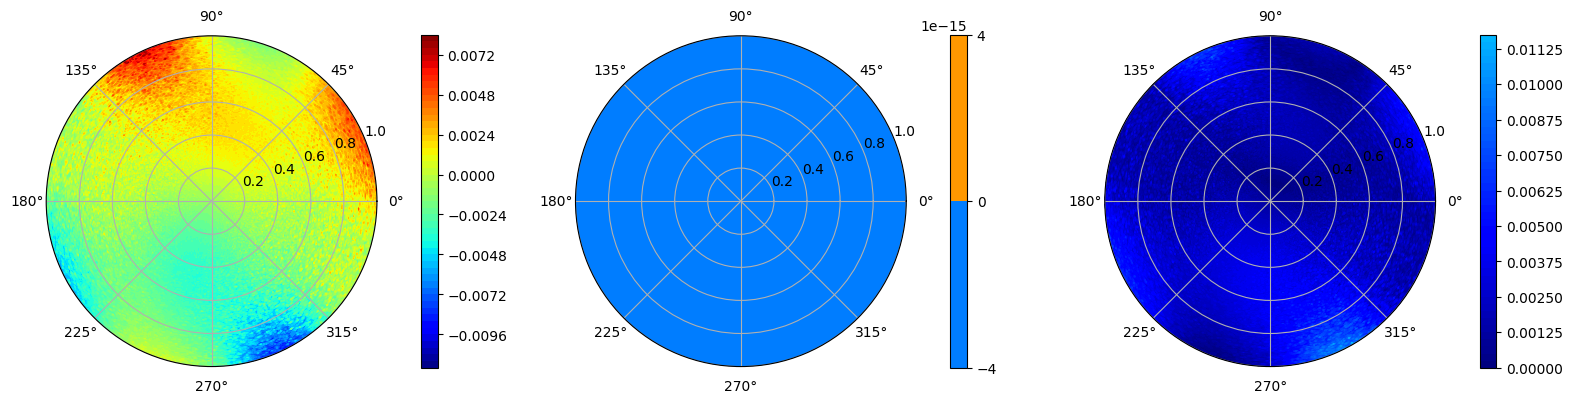

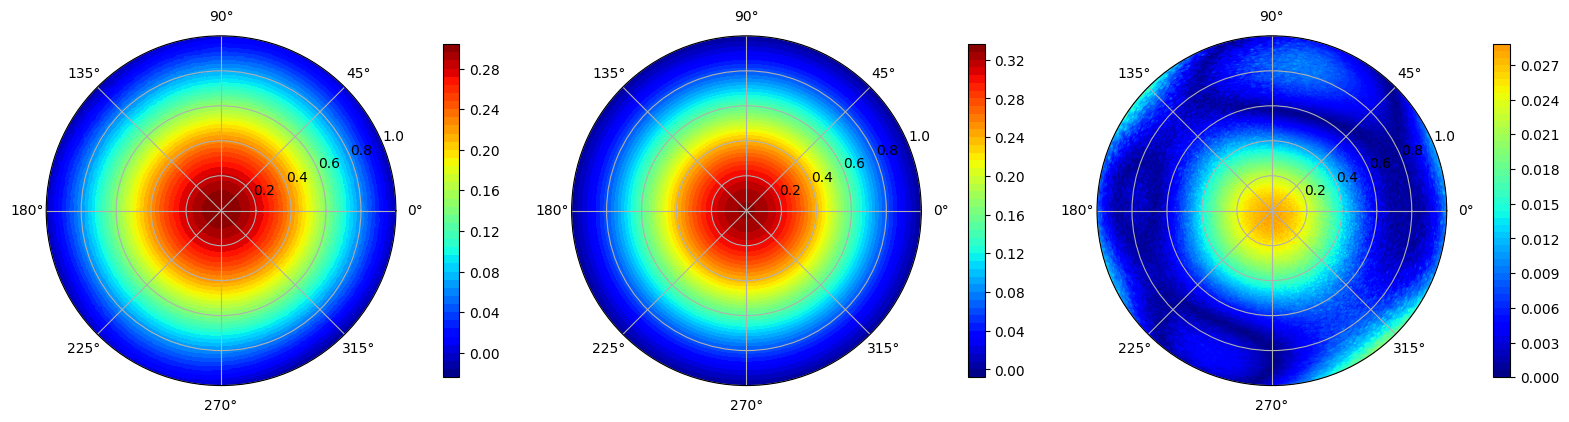

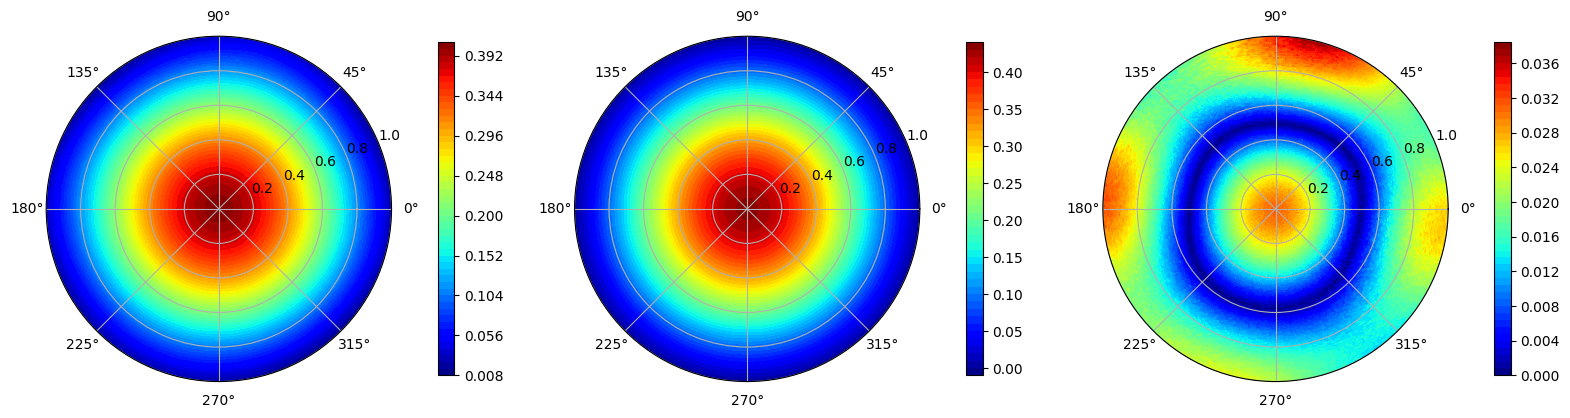

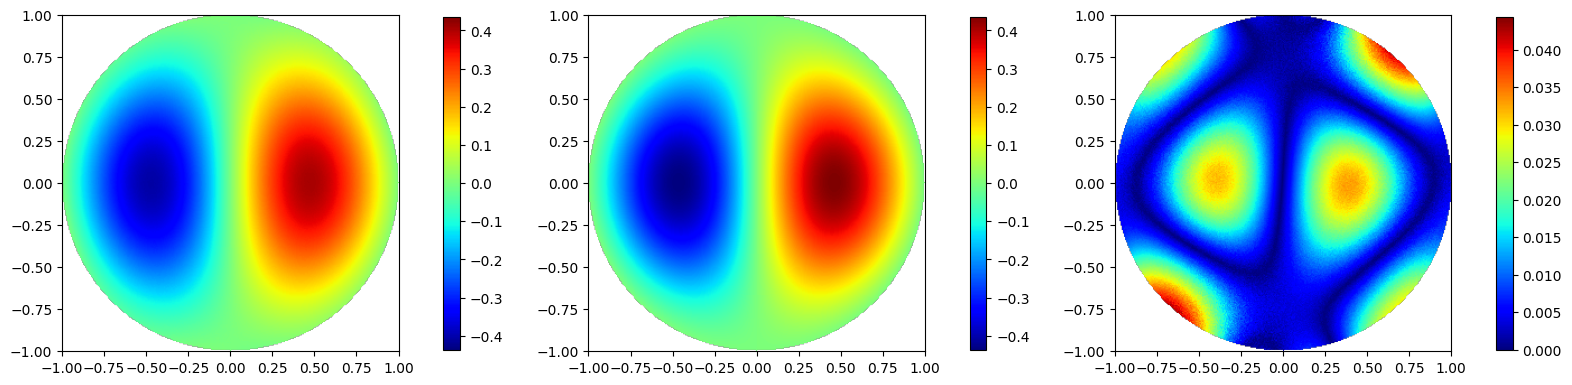

In [ ]:
plot_slices(model, model.device, z0_list=(0.0, 0.25, 0.5))

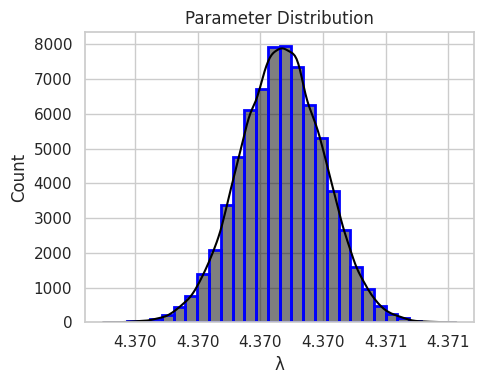

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set(rc={'figure.figsize':(4, 4)})
sns.set_style("whitegrid")

samples = model.lambda_param.detach().cpu().numpy().flatten()
df = pd.DataFrame(samples, columns=['lambda_param'])

plt.figure(figsize=(5, 4))
sns.histplot(df['lambda_param'], kde=True, linewidth=2, edgecolor='blue', color='black', bins=30)
plt.xlabel('λ')
plt.ylabel('Count')
plt.title('Parameter Distribution')

# Set x-axis values to 2 decimal points
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.3f}'))

plt.tight_layout()
plt.savefig('3D_histogram.png', dpi=400)
plt.show()

In [ ]:
def plot_loss_history(model):
    epochs = range(len(model.loss_history))
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, model.loss_history, label='Total Loss')
    plt.plot(epochs, model.li_history, label='PDE Loss')
    plt.plot(epochs, model.lb_history, label='BC Loss')
    plt.plot(epochs, model.ld_history, label='Data Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('3D_loss.png', dpi=400)
    plt.show()

In [ ]:
def plot_loss_history_log(model):
    epochs = range(len(model.loss_history))
    plt.figure(figsize=(8, 6))
    plt.semilogy(epochs, model.loss_history, label='Total Loss')
    plt.semilogy(epochs, model.li_history, label='PDE Loss')
    plt.semilogy(epochs, model.lb_history, label='BC Loss')
    plt.semilogy(epochs, model.ld_history, label='Data Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (log scale)')
    plt.title('Loss Over Epochs (log scale)')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
    plt.tight_layout()
    plt.savefig('3D_log_loss.png', dpi=400)
    plt.show()

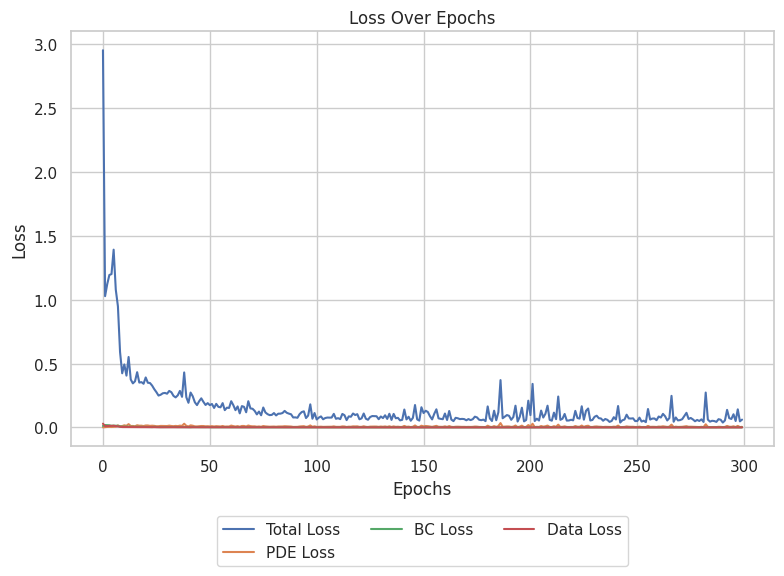

In [ ]:
plot_loss_history(model)

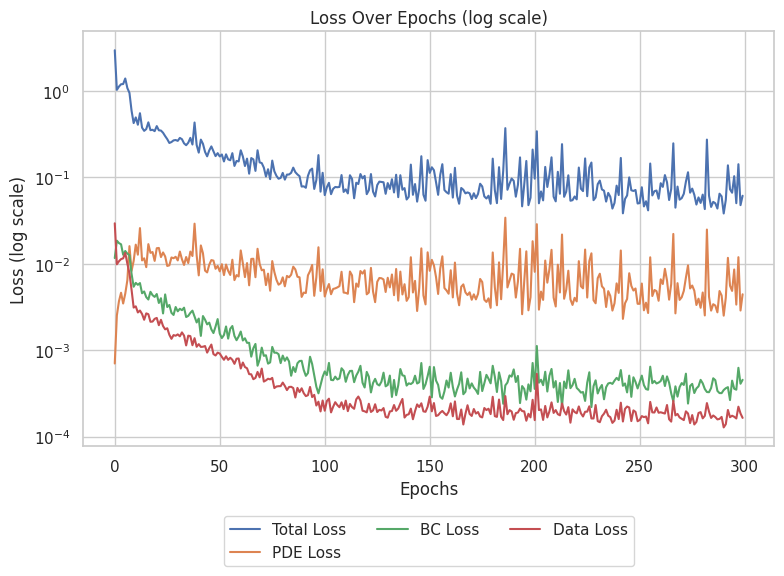

In [ ]:
plot_loss_history_log(model)

In [ ]:
def plot_axis(model):
    z = torch.linspace(-1,1,200,device=model.device)
    pts = torch.stack([torch.zeros_like(z), torch.zeros_like(z), z], dim=1)
    with torch.no_grad():
        u_pred = model(pts).cpu().numpy()
    z_np = z.cpu().numpy()
    u_ex = exact_solution(pts[:,0],pts[:,1],pts[:,2]).cpu().numpy()

    plt.figure(figsize=(5, 4))
    plt.plot(z_np, u_pred, label='Predicted')
    plt.plot(z_np, u_ex, '--', label='Exact')
    plt.legend()
    plt.xlabel('z')
    plt.ylabel('u')
    plt.title('Axis (x=y=0)')
    plt.tight_layout()
    plt.savefig('3D_Axis_plot.png', dpi=400)
    plt.show()

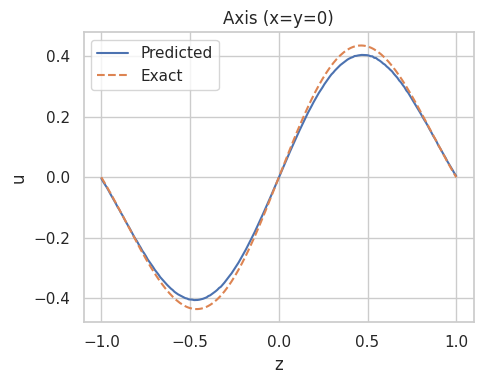

In [ ]:
plot_axis(model)